# Computer Vision 2023 Assignment 2: Image matching and retrieval

In this prac, you will experiment with image feature detectors, descriptors and matching. There are 3 main parts to the prac:

- matching an object in a pair of images
- searching for an object in a collection of images
- analysis and discussion of results

## General instructions

As before, you will use this notebook to run your code and display your results and analysis. Again we will mark a PDF conversion of your notebook, referring to your code if necessary, so you should ensure your code output is formatted neatly. 

***When converting to PDF, include the outputs and analysis only, not your code.*** You can do this from the command line using the `nbconvert` command (installed as part of Jupyter) as follows:

   
   
This will also remove the preamble text from each question. It has been packaged into a small notebook you can run in colab, called notebooktopdf.ipynb


We will use the `OpenCV` library to complete the prac. It has several built in functions that will be useful. You are expected to consult documentation and use them appropriately.

As with the last assignment it is somewhat up to you how you answer each question. Ensure that the outputs and report are clear and easy to read so that the markers can rapidly assess what you have done, why, and how deep is your understanding. This includes:

- sizing, arranging and captioning image outputs appropriately
- explaining what you have done clearly and concisely
- clearly separating answers to each question

## Data

We have provided some example images for this assignment, available through a link on the MyUni assignment page. The images are organised by subject matter, with one folder containing images of book covers, one of museum exhibits, and another of urban landmarks. You should copy these data into a directory A2_smvs, keeping the directory structure the same as in the zip file.  

Within each category (within each folder), there is a “Reference” folder containing a clean image of each object and a “Query” folder containing images taken on a mobile device. Within each category, images with the same name contain the same object (so 001.jpg in the Reference folder contains the same book as 001.jpg in the Query folder).
The data is a subset of the Stanford Mobile Visual Search Dataset which is available at 

<http://web.cs.wpi.edu/~claypool/mmsys-dataset/2011/stanford/index.html>. 

The full data set contains more image categories and more query images of the objects we have provided, which may be useful for your testing!

Do not submit your own copy of the data or rename any files or folders! For marking, we will assume the datasets are available in subfolders of the working directory using the same folder names provided.

Here is some general setup code, which you can edit to suit your needs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pwd
%cd drive/MyDrive/Colab\ Notebooks
!pwd

In [1]:
# Numpy is the main package for scientific computing with Python. 
import numpy as np
import cv2

# Matplotlib is a useful plotting library for python 
import matplotlib.pyplot as plt
# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots, can be changed
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
def draw_outline(ref, query, model):
    """
        Draw outline of reference image in the query image.
        This is just an example to show the steps involved.
        You can modify to suit your needs.
        Inputs:
            ref: reference image
            query: query image
            model: estimated transformation from query to reference image
    """
    h,w = ref.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,model)
    
    img = query.copy()
    img = cv2.polylines(img,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    plt.imshow(img, 'gray'), plt.show()

def draw_inliers(img1, img2, kp1, kp2, matches, matchesMask):
    """
        Draw inlier between images
        img1 / img2: reference/query  img
        kp1 / kp2: their keypoints
        matches : list of (good) matches after ratio test
        matchesMask: Inlier mask returned in cv2.findHomography() 
    """
    matchesMask = matchesMask.ravel().tolist()
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params)
    plt.imshow(img3, 'gray'),plt.show()


# Question 1: Matching an object in a pair of images (60%)


In this question, the aim is to accurately locate a reference object in a query image, for example:

![Books](book.png "Books")

0. Download and read through the paper [ORB: an efficient alternative to SIFT or SURF](https://www.researchgate.net/publication/221111151_ORB_an_efficient_alternative_to_SIFT_or_SURF) by Rublee et al. You don't need to understand all the details, but try to get an idea of how it works. ORB combines the FAST corner detector (covered in week 3) and the BRIEF descriptor. BRIEF is based on similar ideas to the SIFT descriptor we covered week 3, but with some changes for efficiency.

1. [Load images] Load the first (reference, query) image pair from the "book_covers" category using opencv (e.g. `img=cv2.imread()`). Check the parameter option in "
cv2.imread()" to ensure that you read the gray scale image, since it is necessary for computing ORB features.

2. [Detect features] Create opencv ORB feature extractor by `orb=cv2.ORB_create()`. Then you can detect keypoints by `kp = orb.detect(img,None)`, and compute descriptors by `kp, des = orb.compute(img, kp)`. You need to do this for each image, and then you can use `cv2.drawKeypoints()` for visualization.

3. [Match features] As ORB is a binary feature, you need to use HAMMING distance for matching, e.g., `bf = cv2.BFMatcher(cv2.NORM_HAMMING)`. Then you are requried to do KNN matching (k=2) by using `bf.knnMatch()`. After that, you are required to use "ratio_test" to find good matches. By default, you can set `ratio=0.8`.

4. [Plot and analyze] You need to visualize the matches by using the `cv2.drawMatches()` function. Also you can change the ratio values, parameters in `cv2.ORB_create()`, and distance functions in `cv2.BFMatcher()`. Please discuss how these changes influence the match numbers.


In [5]:
# load images as grey scale
img1 = cv2.imread('a2/A2_smvs/book_covers/Reference/001.jpg', 0)
if not np.shape(img1):
  # Error message and print current working dir
  print("Could not load img1. Check the path, filename and current working directory\n")
  !pwd
img2 = cv2.imread("a2/A2_smvs/book_covers/Query/001.jpg", 0)
if not np.shape(img2):
  # Error message and print current working dir
  print("Could not load img2. Check the path, filename and current working directory\n")
  !pwd

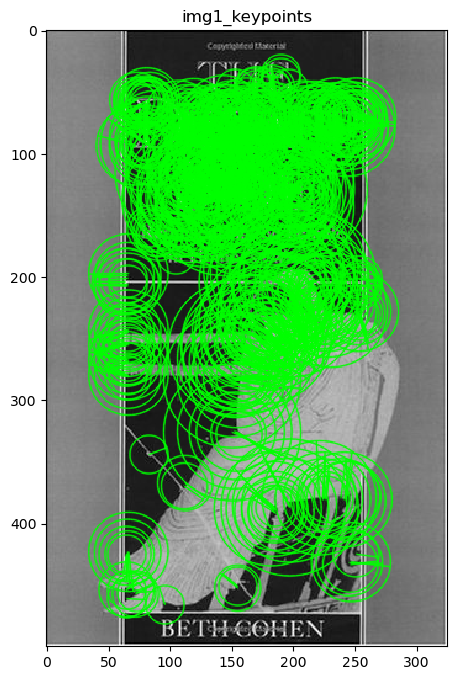

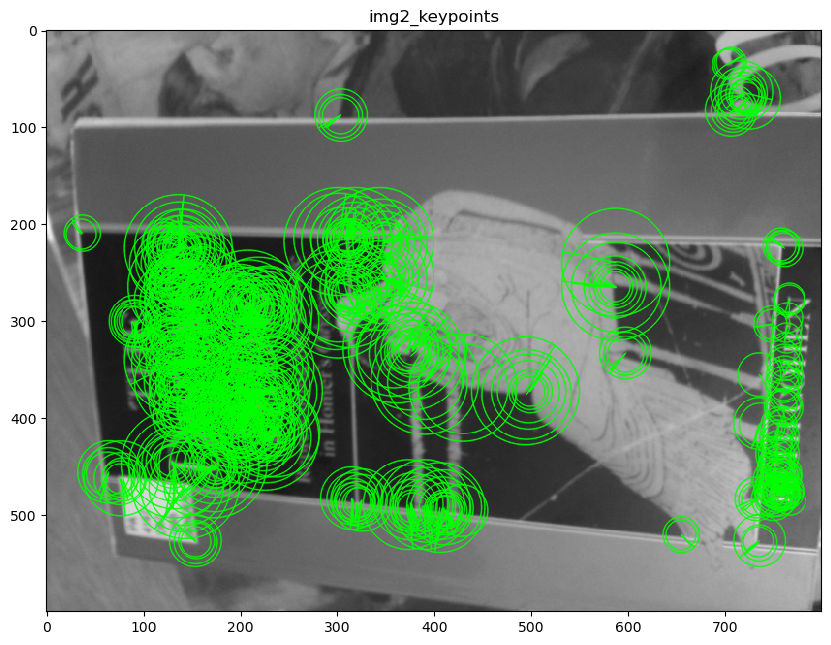

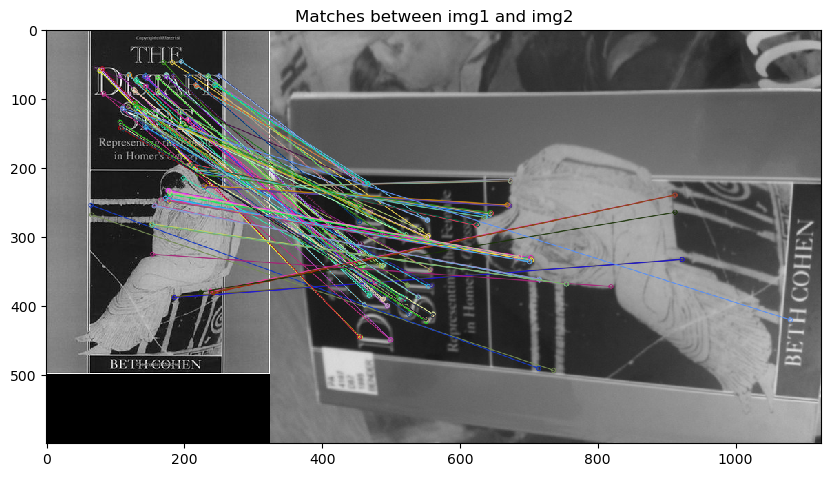

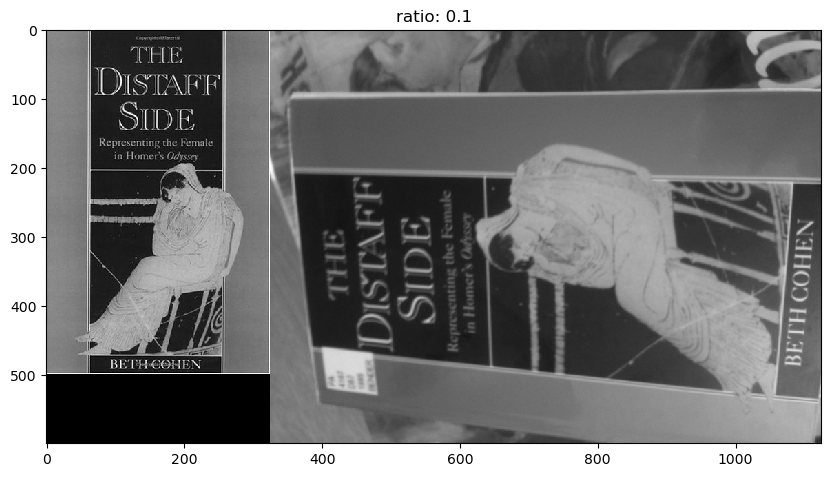

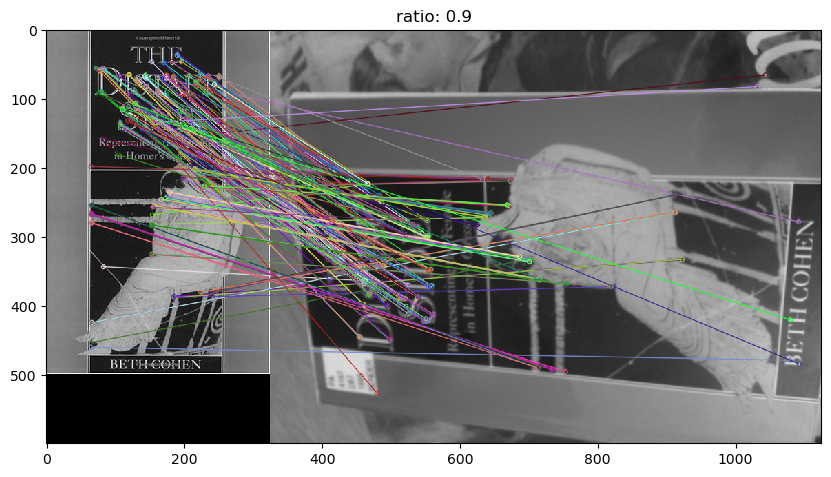

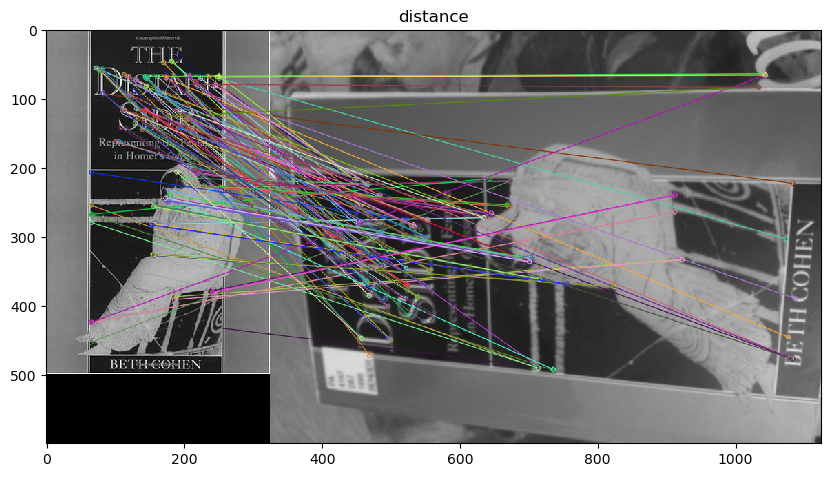

In [21]:
# Your code for descriptor matching tests here

# compute detector and descriptor, see (2) above
# [Detect features] Create opencv ORB feature extractor by `orb=cv2.ORB_create()`.
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB, see (2) above
# Detect keypoints and compute descriptors for img1
kp1, des1 = orb.detectAndCompute(img1, None)
# Detect keypoints and compute descriptors for img2
kp2, des2 = orb.detectAndCompute(img2, None)

# draw keypoints, see (2) above
img1_keypoints = cv2.drawKeypoints(img1, kp1, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_keypoints = cv2.drawKeypoints(img2, kp2, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# create BFMatcher object, see (3) above
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

# Match descriptors, see (3) above
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test, see (3) above
#good = []
#for m,n in matches:
good = []
ratio = 0.8
for m, n in matches:
    if m.distance < ratio * n.distance:
        good.append(m)

# draw matches, see (4) above
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# show the matching result:
plt.imshow(img1_keypoints)
plt.title('img1_keypoints')
plt.show()

plt.imshow(img2_keypoints)
plt.title('img2_keypoints')
plt.show()

plt.imshow(img3)
plt.title('Matches between img1 and img2')
plt.show()

# 4 comparison
# ratio changing 1
com1 = []
ratio = 0.1
for m, n in matches:
    if m.distance < ratio * n.distance:
        com1.append(m)

img4 = cv2.drawMatches(img1, kp1, img2, kp2, com1, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img4)
plt.title('ratio: 0.1')
plt.show()

# ratio changing 2
com2 = []
ratio = 0.9
for m, n in matches:
    if m.distance < ratio * n.distance:
        com2.append(m)

img5 = cv2.drawMatches(img1, kp1, img2, kp2, com2, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img5)
plt.title('ratio: 0.9')
plt.show()

# distance functions comparison
# Euclidean distance
bf1 = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

matches1 = bf1.knnMatch(des1, des2, k=2)

#good = []
#for m,n in matches:
good = []
ratio = 0.9
for m, n in matches1:
    if m.distance < ratio * n.distance:
        good.append(m)

# draw matches, see (4) above
img6 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img6)
plt.title('distance changing comparing with ratio 0.9 img')
plt.show()


***Your explanation of what you have done, and your results, here***

1. I changed the value of ratio to 0.1 and 0.9. When I am using a smaller ratio value (0.1), the number of matched pairs filtered out is lower. When I am using a larger ratio value (0.9), the number of matched pairs is higher. In summary, the smaller ratio value will filter the pairs strictly, while the larger value is, the match is more lenient.

2. I also changed the distance function. I changed the Hamming distance to the Euclidean distance. In the result of Euclidean distance I can see that there are more matches. The Euclidean distance function makes the image matching filter conditions more lenient in this graph

3. Estimate a homography transformation based on the matches, using `cv2.findHomography()`. Display the transformed outline of the first reference book cover image on the query image, to see how well they match.

    - We provide a function `draw_outline()` to help with the display, but you may need to edit it for your needs.
    - Try the 'least squre method' option to compute homography, and visualize the inliers by using `cv2.drawMatches()`. Explain your results.
    - Again, you don't need to compare results numerically at this stage. Comment on what you observe visually.

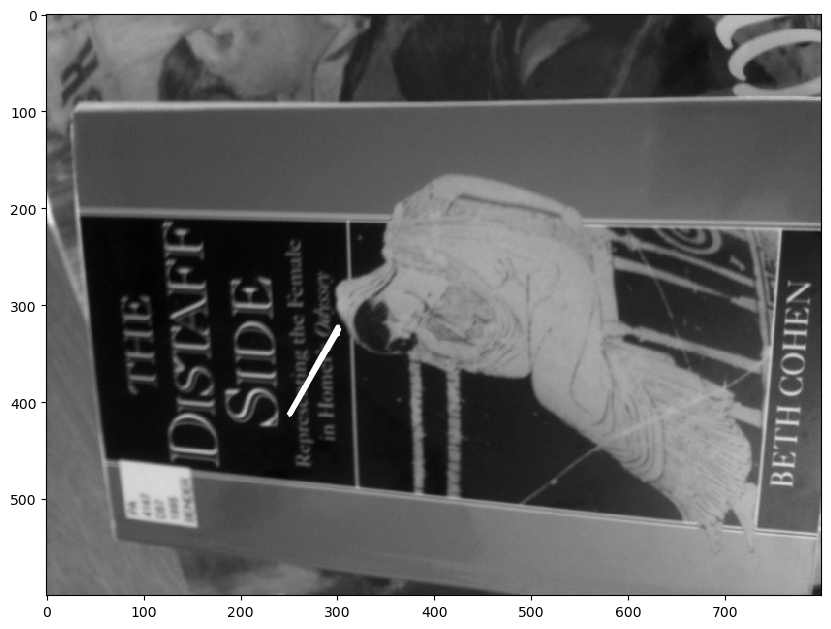

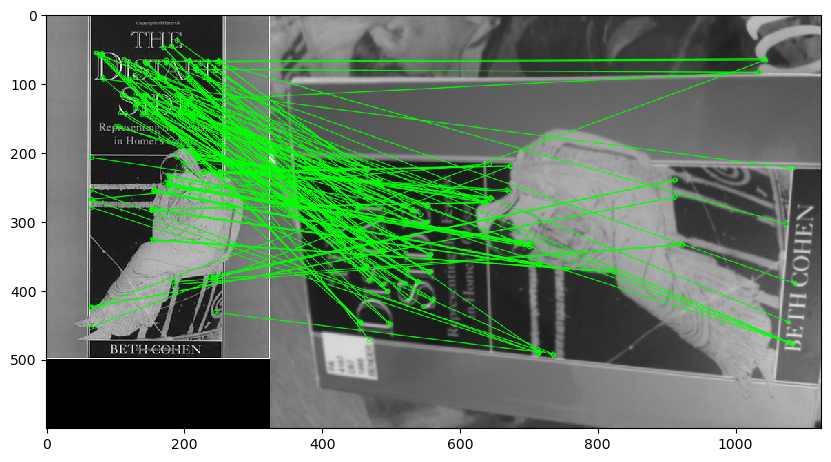

In [29]:
# Create src_pts and dst_pts as float arrays to be passed into cv2.,findHomography
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

# using cv2 standard method, see (3) above
homography, mask = cv2.findHomography(src_pts, dst_pts)

# draw frame
draw_outline(img1, img2, homography)
# draw inliers
draw_inliers(img1, img2, kp1, kp2, good, mask)


***Your explanation of results here***

I found that this picture has only one straight line for outline and many for inlier. Therefore, only a few points are considered as interior points while most of them are considered as exterior points when estimating the single-strain transformation.

Try the RANSAC option to compute homography. Change the RANSAC parameters, and explain your results. Print and analyze the inlier numbers.

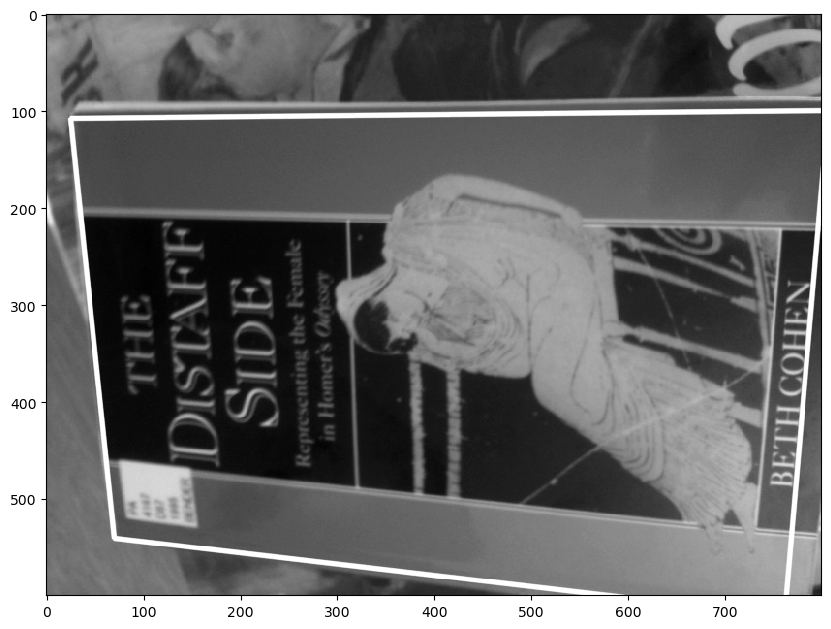

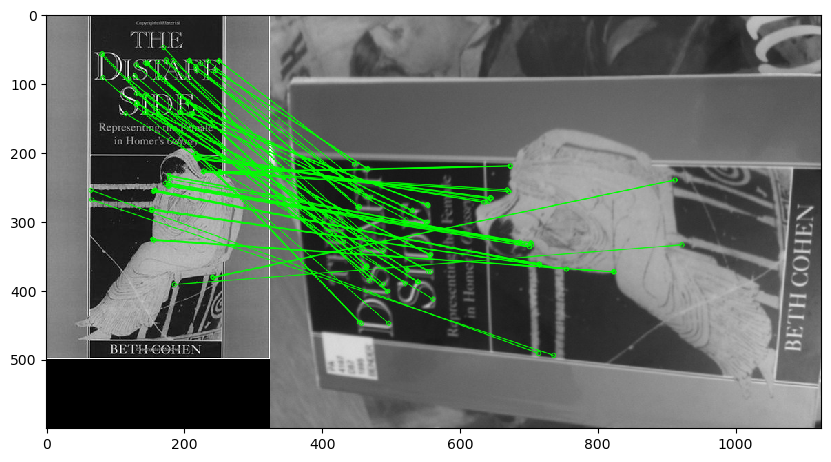

Number of inliers: 87


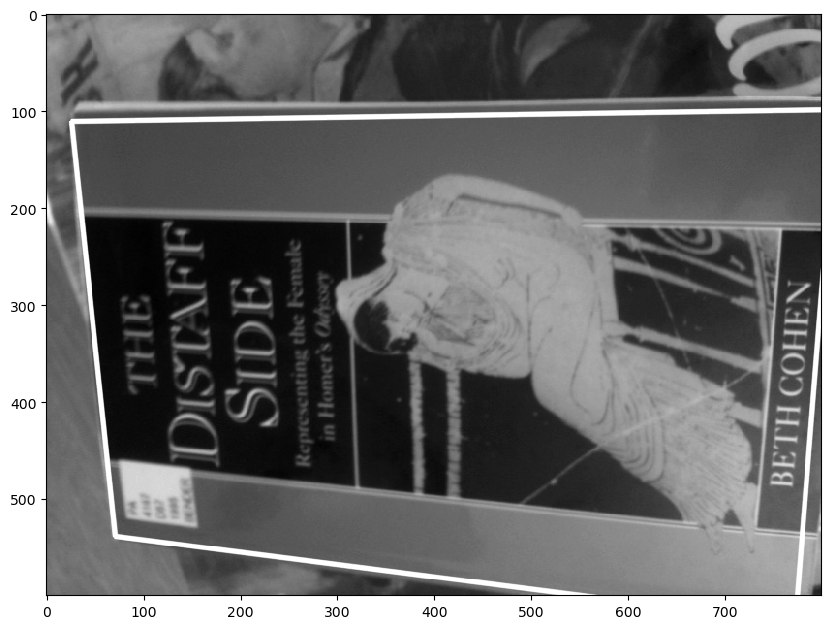

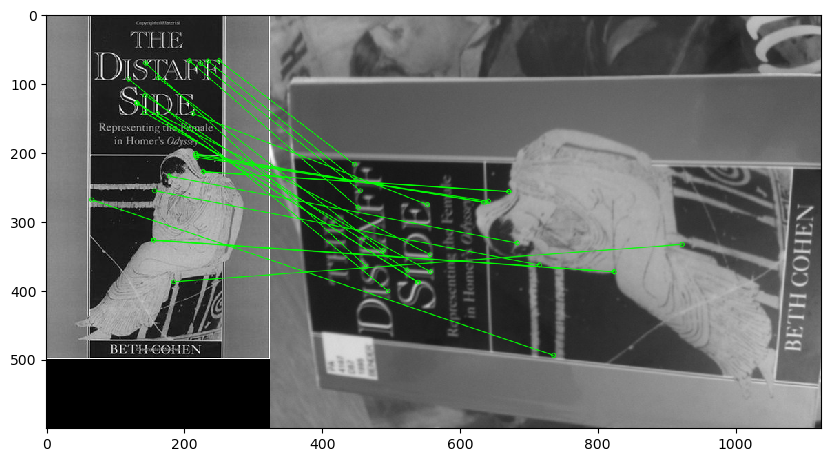

Number of inliers: 24


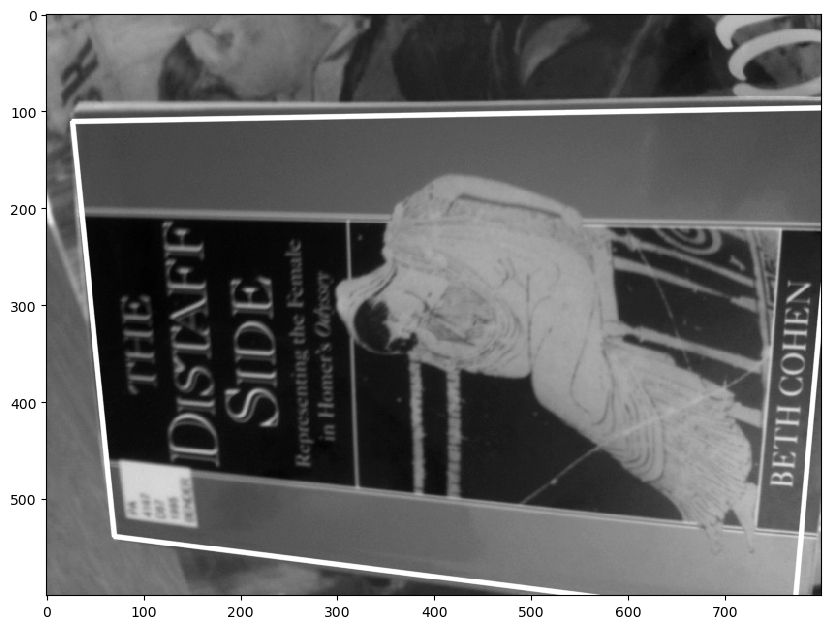

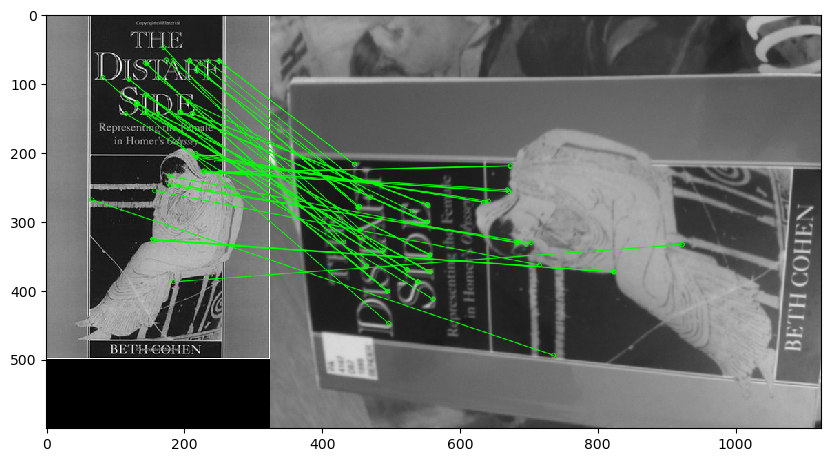

Number of inliers: 50


In [36]:
# Your code to display book location after RANSAC here
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

# using RANSAC
homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# draw frame
draw_outline(img1, img2, homography)

# draw inliers
draw_inliers(img1, img2, kp1, kp2, good, mask)

# inlier number
inlier_num = np.sum(mask)
print("Number of inliers:", inlier_num)

# comparison
homography1, mask1 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0)
draw_outline(img1, img2, homography1)
draw_inliers(img1, img2, kp1, kp2, good, mask1)
inlier_num1 = np.sum(mask1)
print("Number of inliers:", inlier_num1)

homography2, mask2 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2.0)
draw_outline(img1, img2, homography2)
draw_inliers(img1, img2, kp1, kp2, good, mask2)
inlier_num2 = np.sum(mask2)
print("Number of inliers:", inlier_num2)

***Your explanation of what you have tried, and results here***

1. By changing the threshold, I observed that my outline became more accurate compared to the default threshold. 
2. I also experimented with different values for the maximum number of iterations and noticed that increasing the maximum iterations resulted in more inliers, while decreasing it led to fewer inliers.

6. Finally, try matching several different image pairs from the data provided, including at least one success and one failure case. For the failure case, test and explain what step in the feature matching has failed, and try to improve it. Display and discuss your findings.
    1. Hint 1: In general, the book covers should be the easiest to match, while the landmarks are the hardest.
    2. Hint 2: Explain why you chose each example shown, and what parameter settings were used.
    3. Hint 3: Possible failure points include the feature detector, the feature descriptor, the matching strategy, or a combination of these.

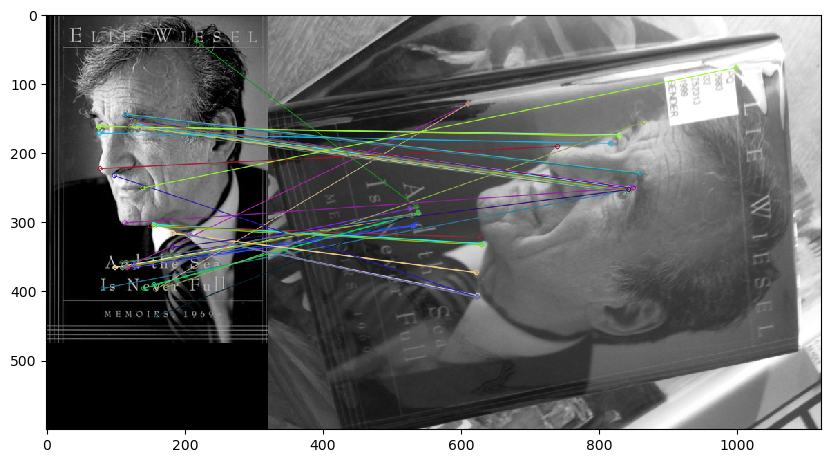

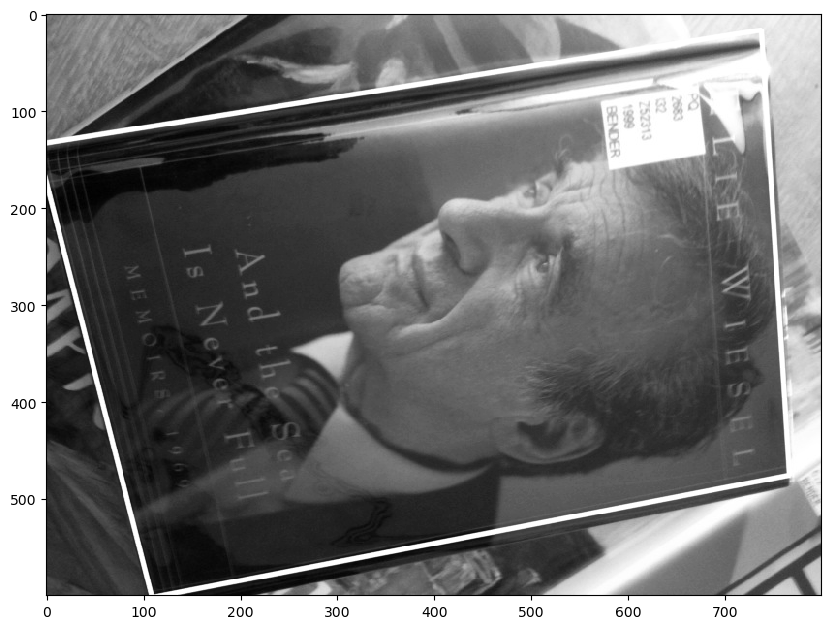

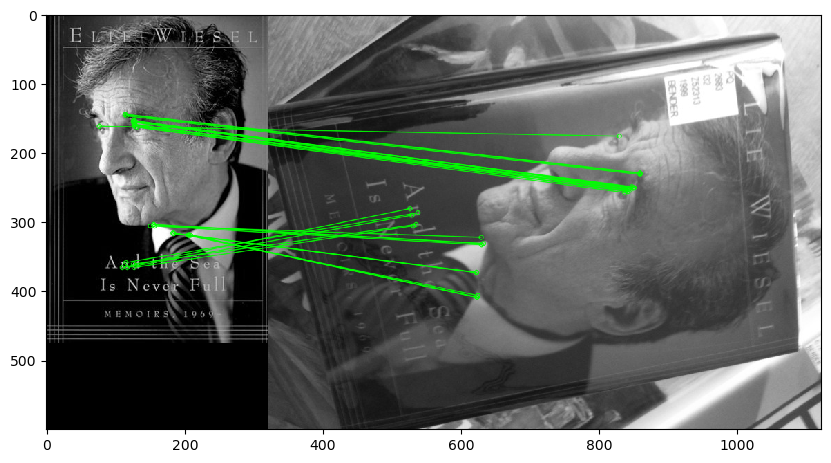

In [70]:
# example 1 book 004
img7 = cv2.imread('a2/A2_smvs/book_covers/Reference/004.jpg', 0)
img8 = cv2.imread("a2/A2_smvs/book_covers/Query/004.jpg", 0)

orb = cv2.ORB_create()
kp3, des3 = orb.detectAndCompute(img7, None)
kp4, des4 = orb.detectAndCompute(img8, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING)

matches = bf.knnMatch(des3, des4, k=2)

#good = []
#for m,n in matches:
good = []
ratio = 0.8
for m, n in matches:
    if m.distance < ratio * n.distance:
        good.append(m)

img39 = cv2.drawMatches(img7, kp3, img8, kp4, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img39)
plt.show()

src_pts1 = np.float32([kp3[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts1 = np.float32([kp4[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
homography, mask = cv2.findHomography(src_pts1, dst_pts1, cv2.RANSAC, 5.0)
draw_outline(img7, img8, homography)
draw_inliers(img7, img8, kp3, kp4, good, mask)


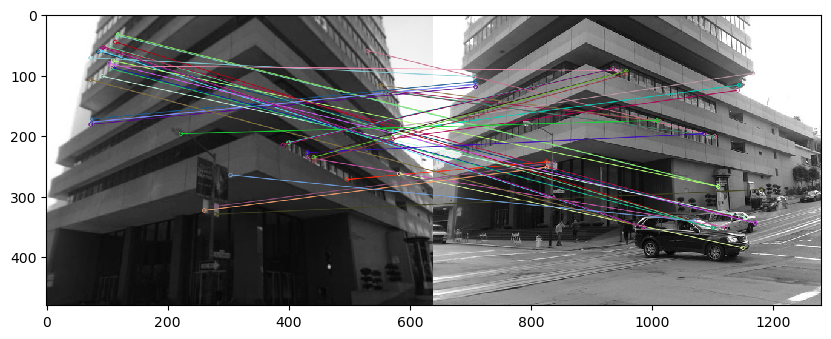

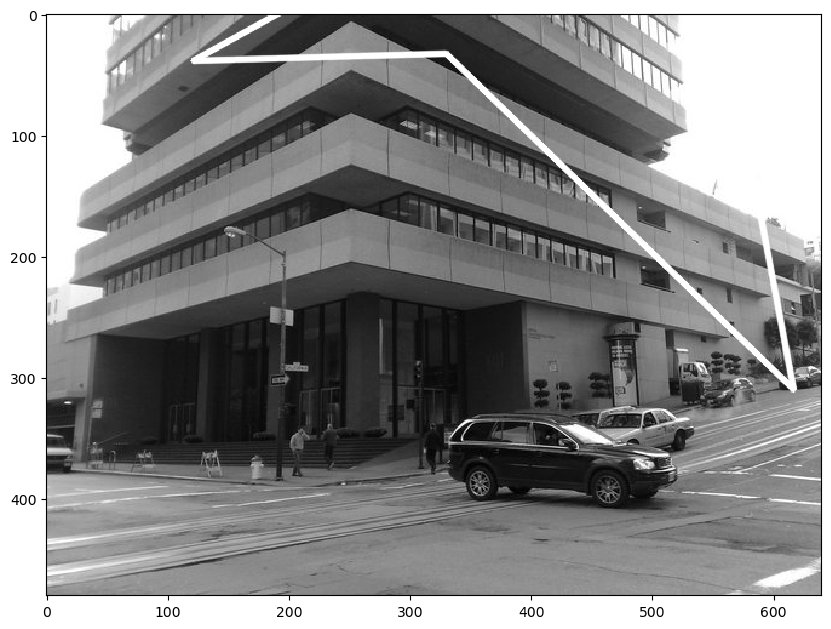

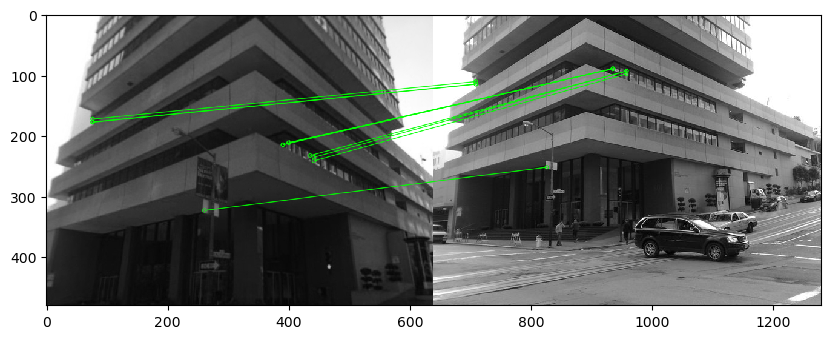

In [83]:
# example 2 landmark
landmark_ref = cv2.imread('a2/A2_smvs/landmarks/Reference/016.jpg', 0)
landmark_que = cv2.imread("a2/A2_smvs/landmarks/Query/016.jpg", 0)

orb = cv2.ORB_create()
landmark_kp1, landmark_des1 = orb.detectAndCompute(landmark_ref, None)
landmark_kp2, landmark_des2 = orb.detectAndCompute(landmark_que, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING)

matches = bf.knnMatch(landmark_des1, landmark_des2, k=2)

#good = []
#for m,n in matches:
good = []
ratio = 0.85
for m, n in matches:
    if m.distance < ratio * n.distance:
        good.append(m)

landmark_matches = cv2.drawMatches(landmark_ref, landmark_kp1, landmark_que, landmark_kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(landmark_matches)
plt.show()

src_pts2 = np.float32([landmark_kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts2 = np.float32([landmark_kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
homography, mask = cv2.findHomography(src_pts2, dst_pts2, cv2.RANSAC, 5.0)
draw_outline(landmark_ref, landmark_que, homography)
draw_inliers(landmark_ref, landmark_que, landmark_kp1, landmark_kp2, good, mask)

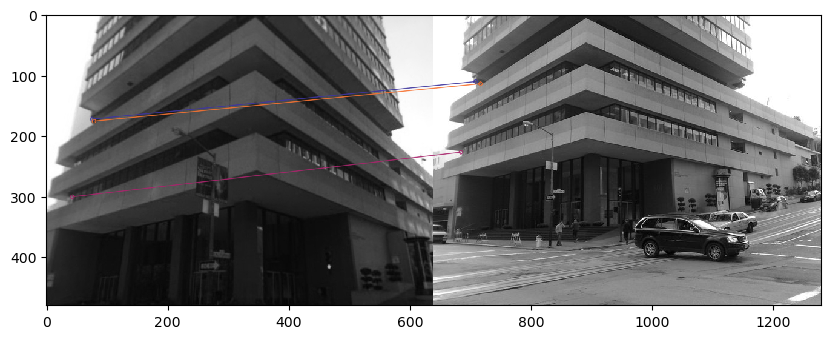

In [97]:
# landmark example improvement
src_pts3 = []
dst_pts3 = []

for m in good:
    src_pts3.append(landmark_kp1[m.queryIdx].pt)
    dst_pts3.append(landmark_kp2[m.trainIdx].pt)

src_pts3 = np.float32(src_pts3).reshape(-1, 1, 2)
dst_pts3 = np.float32(dst_pts3).reshape(-1, 1, 2)

disparities = dst_pts2[:, 0, 0] - src_pts2[:, 0, 0]
mean_disparity = np.mean(disparities)

# disparity tolerance
disparity_tolerance = 6.0

consistent_matches = []
for i in range(len(good)):
    # check if the absolute difference between the disparity and mean disparity is within the tolerance
    if np.abs(disparities[i] - mean_disparity) <= disparity_tolerance:
        consistent_matches.append(good[i])

consistent_matches_img = cv2.drawMatches(landmark_ref, landmark_kp1, landmark_que, landmark_kp2, consistent_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(consistent_matches_img)
plt.show()



***Your explanation of results here***

1. success case: Book cover matching
The reason why I choose the book cover image to match is because the book cover has distinctive features and patterns. Also the book name makes it relatively easier to match.

Parameter Settings: detector and the descriptor : ORB with default settings. Matching Strategy: Brute-Force Matcher with Hamming distance. Matching Ratio: 0.8.

With this algorithm, image matching works well.

2. failure case: Landmark Matching
Parameter Settings: detector and the descriptor : ORB with default settings. Matching Strategy: Brute-Force Matcher with Hamming distance. Matching Ratio: 0.8.

In this case, it fails to produce accurate matches estimation. The prossible failure reasons are:
    - There is an obstruction in front of the building, making it difficult for the feature detector to identify reliable keypoints.
    - In addition to the factors mentioned earlier, the failure in matching can also be attributed to the mismatch in visual rotation and translation between the images. When the images have significant rotational or translational differences, it becomes more challenging for the feature matching algorithm to find reliable correspondences.

3. improvement:
I calculated the average parallax by averaging over all parallaxes. And set a parallax tolerance to determine the acceptable range of parallax for consistent matching, which is 6.0. After that, I iterated over the good matches and selects only those matches whose parallax is within the tolerance range. 

# Question 2: What am I looking at? (40%)


<!--One application of feature matching is image retrieval. The goal of image retrieval is, given a query image of an object, to find all images in a database containing the same object, and return the results in ranked order (like a Google search). This is a huge research area but we will implement a very basic version of the problem based on the small dataset provided.-->

In this question, the aim is to identify an "unknown" object depicted in a query image, by matching it to multiple reference images, and selecting the highest scoring match. Since we only have one reference image per object, there is at most one correct answer. This is useful for example if you want to automatically identify a book from a picture of its cover, or a painting or a geographic location from an unlabelled photograph of it.

The steps are as follows:

1. Select a set of reference images and their corresponding query images. 

    1. Hint 1: Start with the book covers, or just a subset of them.
    3. Hing 2: This question can require a lot of computation to run from start to finish, so cache intermediate results (e.g. feature descriptors) where you can.
    
2. Choose one query image corresponding to one of your reference images. Use RANSAC to match your query image to each reference image, and count the number of inlier matches found in each case. This will be the matching score for that image.

3. Identify the query object. This is the identity of the reference image with the highest match score, or "not in dataset" if the maximum score is below a threshold.

4. Repeat steps 2-3 for every query image and report the overall accuracy of your method (that is, the percentage of query images that were correctly matched in the dataset). Discussion of results should include both overall accuracy and individual failure cases.

    1. Hint 1: In case of failure, what ranking did the actual match receive? If we used a "top-k" accuracy measure, where a match is considered correct if it appears in the top k match scores, would that change the result?

<!--Code to implement this algorithm should mostly be written in a supporting file such as a2code.py. Call your code and display outputs in the notebook below.--> 


In [138]:
from a2code import *

# Select a set of reference images and their corresponding query images
books_ref_des = []
books_ref_kp = []

books_query_des = []
books_query_kp = []

# Compute descriptors for reference images
for img in book_ref:
    cur_kp, cur_ref = compute_descriptors(img, 2000)
    books_ref_des.append(cur_ref)
    books_ref_kp.append(cur_kp)

# Compute descriptors for query images
for img in book_query:
    cur_kp, cur_ref = compute_descriptors(img, 2000)
    books_query_des.append(cur_ref)
    books_query_kp.append(cur_kp)

correct = 0
threshold = 6

for i, query in enumerate(book_query):
    max_score = -1
    index = -1
    max_stats = []

    for j, ref in enumerate(book_ref):
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
        matches = bf.knnMatch(books_ref_des[j], books_query_des[i], k=2)
        good = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)
        
        if len(good) > threshold:
            src_pts = np.float32([books_ref_kp[j][m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([books_query_kp[i][m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            score = len(mask.ravel().tolist())

            if max_score < score:
                index = j + 1
                max_score = score
      
    if max_score > threshold:
        if book_labels[i] == index:
            print("Query", book_labels[i], "matches with reference", index, "Score:", max_score)
            correct += 1
        else:
            print("Query", book_labels[i], "does not match with reference", index, "Score:", max_score)
    # "not in dataset" if the maximum score is below a threshold
    else:
        print("Query", book_labels[i], "does not have a matching reference image above the threshold")


accuracy = correct / len(book_query) * 100
print("Overall Accuracy:", accuracy, "%")


Query 1 matches with reference 1 Score: 201
Query 2 matches with reference 2 Score: 126
Query 3 matches with reference 3 Score: 259
Query 4 matches with reference 4 Score: 98
Query 5 matches with reference 5 Score: 154
Query 6 matches with reference 6 Score: 324
Query 7 matches with reference 7 Score: 106
Query 8 matches with reference 8 Score: 45
Query 9 matches with reference 9 Score: 212
Query 10 matches with reference 10 Score: 277
Query 11 matches with reference 11 Score: 211
Query 12 matches with reference 12 Score: 152
Query 13 matches with reference 13 Score: 199
Query 14 matches with reference 14 Score: 105
Query 15 matches with reference 15 Score: 90
Query 16 matches with reference 16 Score: 114
Query 17 matches with reference 17 Score: 90
Query 18 matches with reference 18 Score: 29
Query 19 matches with reference 19 Score: 142
Query 20 matches with reference 20 Score: 269
Query 21 matches with reference 21 Score: 152
Query 22 matches with reference 22 Score: 100
Query 23 ma

The overall accuracy of my method is 91.09%.

Failure cases: Query 55, it does not match with Reference 67 with a score of 19
                Query 64 with Reference 69
                Query 68 with Reference 89 
                Query 71 with Reference 72 
                Query 73 with Reference 77
                Query 75 with Reference 77
                Query 77 with Reference 75 
                Query 90 with Reference 89 
                Query 100 with Reference 34. 

Based on these failures, we can see that the actual match ranking is relatively lower.

This may change the results if we use a "top-k" accuracy measure where a match is considered correct only if it appears in the top k match scores. Because in the original match results, we do not focus on the ranking of the matches, but judge the accuracy of the matches based on the highest match scores.

***Your explanation of what you have done, and your results, here***

5. Choose some extra query images of objects that do not occur in the reference dataset. Repeat step 4 with these images added to your query set. Accuracy is now measured by the percentage of query images correctly identified in the dataset, or correctly identified as not occurring in the dataset. Report how accuracy is altered by including these queries, and any changes you have made to improve performance.

In [159]:
# Your code to run extra queries and display results here
from a2code import *
correct = 0

for i, img1 in enumerate(books_query[0:100]):
  # image 0 - 100
    index = -1
    max_score = -1

    for j, img2 in enumerate(books_ref[0:40]):
      # image 0 - 40
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
        matches = bf.knnMatch(books_ref_des[j], books_query_des[i], k=2)

        good = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)
        
        # update the maximum score and index
        if len(good) > 5:
          # calculate the homography and get the score
          src_pts = np.float32([ books_ref_kp[j][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
          dst_pts = np.float32([ books_query_kp[i][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
          M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
          score = len(mask.ravel().tolist())

          if max_score < score:
            index = j + 1
            max_score = score
    
    if max_score < 50:
      # threshold = 20
      if i >= 40:
        print("Score:", str(max_score) + " Query image: ", books_labels[i], "not in ref dataset. Correct! ")
        correct += 1
      else:
        print("Score:", str(max_score) + " Query image: ", books_labels[i], "in ref dataset. Incorrect!")
    else:
      if i >= 40:
        print("Score:", str(max_score) + " Query image: ", books_labels[i], "not in ref dataset but matched. Incorrect!")
      elif index == books_labels[i]:
        print("Score:", str(max_score) + " Query image: ", books_labels[i], "in ref dataset and matched. Correct!")
        correct += 1
      elif index != books_labels[i]:
        print("Score:", str(max_score) + " Query image: ", books_labels[i], "not in ref dataset. Incorrect!")
      
accuracy = correct / len(book_query) * 100
print("Overall Accuracy:", accuracy, "%")

Score: 201 Query image  1 in ref dataset and matched. Correct!
Score: 126 Query image  2 in ref dataset and matched. Correct!
Score: 259 Query image  3 in ref dataset and matched. Correct!
Score: 98 Query image  4 in ref dataset and matched. Correct!
Score: 154 Query image  5 in ref dataset and matched. Correct!
Score: 324 Query image  6 in ref dataset and matched. Correct!
Score: 106 Query image  7 in ref dataset and matched. Correct!
Score: 45 Query image:  8 in ref dataset. Incorrect!
Score: 212 Query image  9 in ref dataset and matched. Correct!
Score: 277 Query image  10 in ref dataset and matched. Correct!
Score: 211 Query image  11 in ref dataset and matched. Correct!
Score: 152 Query image  12 in ref dataset and matched. Correct!
Score: 199 Query image  13 in ref dataset and matched. Correct!
Score: 105 Query image  14 in ref dataset and matched. Correct!
Score: 90 Query image  15 in ref dataset and matched. Correct!
Score: 114 Query image  16 in ref dataset and matched. Correc

***Your explanation of results and any changes made here***

After including extra query images of objects that do not occur in the reference dataset, the overall accuracy has increased to 94.05%.

To achieve this accuracy, I made the following changes to improve performance:
I expanded the query set. When my query set is 50, the accuracy is 44.55%. When my query set is 70, the accuracy is 64.35%. When my query set is 100, the accuracy is 94.05%. 
I modified the matching threshold also. I set the minimum score equals to 20, and the accuracy is 97.03%. When the minimum score equals to 50, the accuracy is 94.05%


6. Repeat step 4 and 5 for at least one other set of reference images from museum_paintings or landmarks, and compare the accuracy obtained. Analyse both your overall result and individual image matches to diagnose where problems are occurring, and what you could do to improve performance. Test at least one of your proposed improvements and report its effect on accuracy.


In [160]:
# Your code to search images and display results here
from a2code import *

# Select a set of reference images and their corresponding query images
landmark_ref_des = []
landmark_ref_kp = []

landmark_query_des = []
landmark_query_kp = []

# Compute descriptors for reference images
for img in landmark_ref:
    cur_kp, cur_ref = compute_descriptors(img, 2000)
    landmark_ref_des.append(cur_ref)
    landmark_ref_kp.append(cur_kp)

# Compute descriptors for query images
for img in landmark_query:
    cur_kp, cur_ref = compute_descriptors(img, 2000)
    landmark_query_des.append(cur_ref)
    landmark_query_kp.append(cur_kp)

In [167]:
# Your code to run extra queries and display results here
correct = 0

for i, img1 in enumerate(landmark_query[0:100]):
  # image 0 - 100
    index = -1
    max_score = -1

    for j, img2 in enumerate(landmark_ref[0:40]):
      # image 0 - 40
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
        matches = bf.knnMatch(landmark_ref_des[j], landmark_query_des[i], k=2)

        good = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)
        
        # update the maximum score and index
        if len(good) > 5:
          # calculate the homography and get the score
          src_pts = np.float32([ landmark_ref_kp[j][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
          dst_pts = np.float32([ landmark_query_kp[i][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
          M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
          score = len(mask.ravel().tolist())

          if max_score < score:
            index = j + 1
            max_score = score
    
    if max_score < 20:
      # threshold = 20
      if i >= 40:
        print("Score:", str(max_score) + " Query image: ", landmark_labels[i], "not in ref dataset. Correct! ")
        correct += 1
      else:
        print("Score:", str(max_score) + " Query image: ", landmark_labels[i], "in ref dataset. Incorrect!")
    else:
      if i >= 40:
        print("Score:", str(max_score) + " Query image: ", landmark_labels[i], "not in ref dataset but matched. Incorrect!")
      elif index == landmark_labels[i]:
        print("Score:", str(max_score) + " Query image: ", landmark_labels[i], "in ref dataset and matched. Correct!")
        correct += 1
      elif index != landmark_labels[i]:
        print("Score:", str(max_score) + " Query image: ", landmark_labels[i], "not in ref dataset. Incorrect!")
      
accuracy = correct / len(landmark_query) * 100
print("Overall Accuracy:", accuracy, "%")

Score: 11 Query image:  1 in ref dataset. Incorrect!
Score: 7 Query image:  2 in ref dataset. Incorrect!
Score: 10 Query image:  3 in ref dataset. Incorrect!
Score: 13 Query image:  4 in ref dataset. Incorrect!
Score: 9 Query image:  5 in ref dataset. Incorrect!
Score: 13 Query image:  6 in ref dataset. Incorrect!
Score: 17 Query image:  7 in ref dataset. Incorrect!
Score: 10 Query image:  8 in ref dataset. Incorrect!
Score: 9 Query image:  9 in ref dataset. Incorrect!
Score: 10 Query image:  10 in ref dataset. Incorrect!
Score: 27 Query image:  11 in ref dataset and matched. Correct!
Score: 15 Query image:  12 in ref dataset. Incorrect!
Score: 13 Query image:  13 in ref dataset. Incorrect!
Score: 28 Query image:  14 not in ref dataset. Incorrect!
Score: 9 Query image:  15 in ref dataset. Incorrect!
Score: 12 Query image:  16 in ref dataset. Incorrect!
Score: 14 Query image:  17 in ref dataset. Incorrect!
Score: 19 Query image:  18 in ref dataset. Incorrect!
Score: 15 Query image:  19 

***Your description of what you have done, and explanation of results, here***
For landmark matching, my overall accuracy is 65.0%. 

I set my ratio to 0.6, the overall accuracy is 15%. And then I increase the ratio to 0.7, the accuracy increased. 
I expanded the query set from 70, where the overall accuracy is 32% to 100, where the overall accuracy is 62.0%.
Next I lowered the threshold and I went from 20 to 30, a 3% increase in overall accuracy.
